Load from saved data (usually from experiment.py)

In [2]:
# Setup code

import sys
sys.path.insert(0, "..")

import datetime
import skdim
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import pickle
import re
from sklearn.decomposition import PCA
import ipywidgets as widgets
import matplotlib

from torch.utils.data import DataLoader


import models
import utils

plt.rcParams["figure.figsize"] = (7, 3)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def create_error_tabledict(errors, labels, transposed=False):
  if transposed:
    num_cols = len(labels)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"
    table += "& " + " & ".join([str(label) for label in labels]) + " \\\\\n\\hline\n"

    for row_name, row_values in errors.items():
        table += row_name + " & " + " & ".join([f"{val*100:.2f}" for val in row_values]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"
    return table
  
  else:
    columns = list(errors.keys())
    num_cols = len(columns)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"
    table += "& " + " & ".join([str(col) for col in columns]) + " \\\\\n\\hline\n"

    for label, col_values in zip(labels, zip(*[errors[col] for col in columns])):
        table += str(label) + " & " + " & ".join([f"{val*100:.2f}" for val in col_values]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"
    return table

def create_error_table(errors, labels):
    num_cols = max(len(row) for row in errors)

    table = "\\begin{table}[h]\n\\centering\n"
    table += "\\begin{tabular}{|" + "r|" * (num_cols + 1) + "}\n"
    table += "\\hline\n"

    table += "& " + " & ".join([str(i + 1) for i in range(num_cols)]) + " \\\\\n\\hline\n"

    for label, row in zip(labels, errors):
        table += str(label) + " & " + " & ".join([f"{val*100:.2f}" for val in row]) + " \\\\\n\\hline\n"

    table += "\\end{tabular}\n"
    table += "\\end{table}"

    return table

def plot_projops(self, title, save=False):
  matplotlib.rcParams.update({'font.size': 14})

  fig, ax = plt.subplots(figsize=(8, 5))

  projerrs = self.get_projerr_times()
  operrs = self.get_operrs()

  ax.plot(range(len(projerrs)), projerrs, label="Reconstruction Error")
  ax.plot(range(1, len(operrs)+1), operrs, label="Operator Error")

  for vals in self.windowvals[:-1]:
    v = vals[-1]
    ax.axvline(v+1, linestyle=":", alpha=0.5)

  ax.set_xlabel("t")
  ax.set_ylabel("Relative L2 Error")
  ax.set_yscale("log")
  ax.legend()
  ax.set_title(title)

  fig.tight_layout()
  
  if save:
    plt.savefig(f"{title}-projoperror.pdf")

def get_total_error(self):
  input = torch.tensor(self.dataset.data[:, 0, :]).to(self.device).float()
  references = [self.dataset.data[:, s, :] for s in range(1, self.T)]

  predicteds = self.propagate(input, 0, self.T - 1)
  predictedvals = [self.decode_window(self.find_window(i+1)[0], x).cpu().detach().numpy() for i, x in enumerate(predicteds)]
  
  predicteds = [x.cpu().detach().numpy() for x in predicteds]

  input = input.cpu().detach().numpy()

  errors = []
  totals = []
  for s in range(1, self.T):
    errors.append(np.mean(np.linalg.norm(predictedvals[s-1] - references[s-1], axis=1))) 
    totals.append(np.mean(np.linalg.norm(references[s-1], axis=1)))

  return np.sum(errors)/np.sum(totals)

def get_properr_accum(self):
  data = torch.tensor(self.dataset.data).to(self.device).float()
  input = data[:, 0, :]
  references = [self.encode_window(self.find_window(s)[0], data[:, s, :]).cpu().detach().numpy() for s in range(1, self.T)]

  predicteds = self.propagate(input, 0, self.T - 1)
  predicteds = [x.cpu().detach().numpy() for x in predicteds]

  errors = []
  totals = []
  for s in range(1, self.T):
    errors.append(np.mean(np.linalg.norm(predicteds[s-1] - references[s-1], axis=1))) 
    totals.append(np.mean(np.linalg.norm(references[s-1], axis=1)))

  return [errors[i] / totals[i] for i in range(len(errors))]

Using backend: pytorch



In [6]:
def get_properr_all(self, plot=True, title=None):
  data = torch.tensor(self.dataset.data).to(self.device).float()
  inputs = [data[:, s, :] for s in range(0, self.T-1)]
  references = [self.encode_window(self.find_window(s)[0], data[:, s, :]).cpu().detach().numpy() for s in range(1, self.T)]

  predicteds = [self.propagate(x, s, 1)[-1].cpu().detach().numpy() for s, x in enumerate(inputs)]

  errors = []
  totals = []
  for s in range(self.T-1):
    errors.append(np.mean(np.linalg.norm(predicteds[s] - references[s], axis=1))) 
    totals.append(np.mean(np.linalg.norm(references[s], axis=1)))

  errors = [errors[i] / totals[i] for i in range(len(errors))]

  if plot:
    fig, ax = plt.subplots()

    for vals in self.windowvals[:-1]:
      v = vals[-1]
      ax.axvline(v, linestyle=":", alpha=0.5)

    ax.plot(errors)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative propagator error")

    if title is not None:
      ax.set_title(title)

  return errors

In [7]:
datasets = [("../datasets/kdv/kdv2-scale.mat", "kdv2wide"), 
            ("../datasets/kdv/kdv2-shift.mat", "kdv2wide"),
            ("../datasets/burgers/grfarc2visc0p001-scale.mat", "grfarc2visc0p001"),
            ("../datasets/burgers/grfarc2visc0p001-shift.mat", "grfarc2visc0p001"),
            ("../datasets/transport/hats2_2500_scale.mat", "alldata"),
            ("../datasets/transport/hats2_2500_shift.mat", "alldata"),
            ("../datasets/ks/ksscaleall.mat", "output"),
            ("../datasets/ks/ksshiftall.mat", "output")]

labels = ["KdV-Scale", "KdV-Shift", "Burgers-Scale", "Burgers-Shift", "Transport-Scale", "Transport-Shift", "KS-Scale", "KS-Shift" ]

datasets = datasets[2:3]
labels = labels[2:3]

datasets = datasets
labels = labels

windows = 5
baseepochs = 200

din = 512
k = 3

L = 3
p = 500
L2 = 3
p2 = 300
L3 = 3
p3 = 300

augmentt = True
kk = k
if augmentt:
  kk = k+1

aeclass = models.FFAutoencoder
aeargs = { "encodeSeq": [din] + [p] * L + [k], "decodeSeq": [kk] + [p] * L + [din], "activation": nn.ReLU() }

# aeclass = models.ConvAutoencoder
# pconv = 15
# aeargs = { "encodeSeq": [din] + [pconv] * L + [k], "decodeSeq": [k] + [pconv] * L + [din], "activation": nn.ReLU() }

propclass = models.FFNet
propargs = { "seq": [kk] + [p2] * L2 + [k], "activation": nn.ReLU() }
externalclass = models.FFNet
externalargs = { "seq": [kk] + [p3] * L3 + [k], "activation": nn.ReLU() }

projerrs = []
for i, currdata in enumerate(datasets):
  dataset = utils.DynamicData(currdata)
  dataset.shuffle_inplace()

  dataset.subset_data(800)

  if dataset.data.shape[2] == 2048:
    dataset.downsample(4)
  else:
    dataset.downsample(2)

  if dataset.data.shape[1] == 101:
    dataset.data = dataset.data[:, ::2, :]

  dataset.scaledown()

  prefix = labels[i].lower()
  prefix = re.sub("[^0-9a-zA-Z\s]+", "", prefix)
  prefix = re.sub("transport", "hats", prefix)

  save = False
  straightness = 0
  pca = True
  name = f"{prefix}{straightness}str{windows}w"
  print(name)

  timewindowAE = models.TimewindowAE(dataset, windows, aeclass, aeargs, propclass, propargs, pca=pca, externalclass=externalclass, externalparams=externalargs, 
                              augment=augmentt, tensorboard_directory=f"{name}{hash(time.time()) % 100}", device=device)
  #if pca:
  #  timewindowAE.train_pcas(k=k)
  #else:
  #  timewindowAE.train_aes(int(baseepochs*1.5), warmstart_epochs=baseepochs, straight=straightness, printinterval=25, batch=16, save=True)

  #timewindowAE.train_propagators(int(baseepochs/2), batch=100, externalepochs=baseepochs*4, printinterval=33, save=save)
  timewindowAE.load_aes(prefix)
  timewindowAE.load_props(prefix)

  errors = get_properr_all(timewindowAE, title=name)

  # now loaded, do stuff
  #plot_projops(timewindowAE, name, save=True)
  #print("Finished", name)

burgersscale0str5w
Load failed. Could not match with any files
[]


AssertionError: 

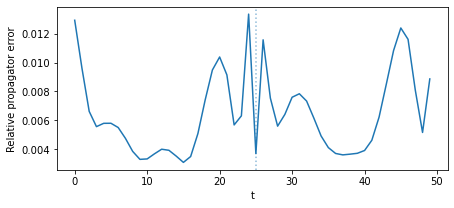

In [4]:
def get_properr_all(self, plot=True):
  data = torch.tensor(self.dataset.data).to(self.device).float()
  inputs = [data[:, s, :] for s in range(0, self.T-1)]
  references = [self.encode_window(self.find_window(s)[0], data[:, s, :]).cpu().detach().numpy() for s in range(1, self.T)]

  predicteds = [self.propagate(x, s, 1)[-1].cpu().detach().numpy() for s, x in enumerate(inputs)]

  errors = []
  totals = []
  for s in range(self.T-1):
    errors.append(np.mean(np.linalg.norm(predicteds[s] - references[s], axis=1))) 
    totals.append(np.mean(np.linalg.norm(references[s], axis=1)))

  errors = [errors[i] / totals[i] for i in range(len(errors))]

  if plot:
    fig, ax = plt.subplots()

    for vals in self.windowvals[:-1]:
      v = vals[-1]
      ax.axvline(v, linestyle=":", alpha=0.5)

    ax.plot(errors)
    ax.set_xlabel("t")
    ax.set_ylabel("Relative propagator error")

  return errors

errors = get_properr_all(timewindowAE)

Text(0, 0.5, 'Relative propagator error')

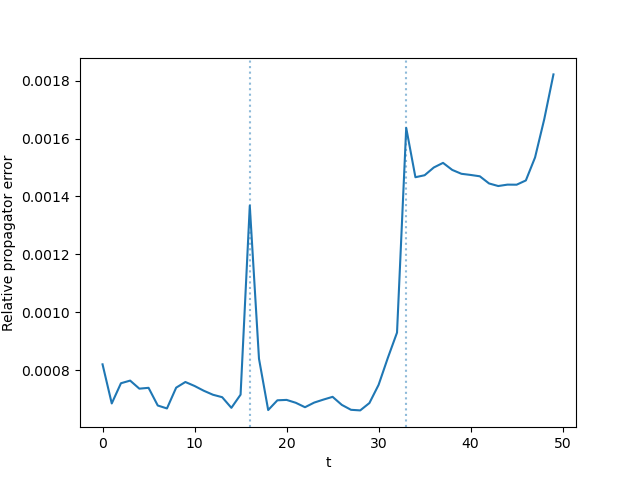

In [2]:
datasets = [("../datasets/kdv/kdv2-scale.mat", "kdv2wide"), 
            ("../datasets/kdv/kdv2-shift.mat", "kdv2wide"),
            ("../datasets/burgers/grfarc2visc0p001-scale.mat", "grfarc2visc0p001"),
            ("../datasets/burgers/grfarc2visc0p001-shift.mat", "grfarc2visc0p001"),
            ("../datasets/transport/hats2_2500_scale.mat", "alldata"),
            ("../datasets/transport/hats2_2500_shift.mat", "alldata"),
            ("../datasets/ks/ksscaleall.mat", "output"),
            ("../datasets/ks/ksshiftall.mat", "output")]

labels = ["KdV-Scale", "KdV-Shift", "Burgers-Scale", "Burgers-Shift", "Transport-Scale", "Transport-Shift", "KS-Scale", "KS-Shift" ]

datasets = datasets[:-1]
windows_list = [1, 3, 5, 15]

baseepochs = 200

din = 512
k = 3

L = 3
p = 500
L2 = 3
p2 = 500
L3 = 3
p3 = 500

aeclass = models.FFAutoencoder
aeargs = { "encodeSeq": [din] + [p] * L + [k], "decodeSeq": [k] + [p] * L + [din], "activation": nn.ReLU() }
propclass = models.FFNet
propargs = { "seq": [k] + [p2] * L2 + [k], "activation": nn.ReLU() }
externalclass = models.FFNet
externalargs = { "seq": [k] + [p3] * L3 + [k], "activation": nn.ReLU() }

errorDict = {}

for i, currdata in enumerate(datasets):
  dataset = utils.DynamicData(currdata)
  dataset.shuffle_inplace()

  dataset.subset_data(800)

  if dataset.data.shape[2] == 2048:
    dataset.downsample(4)
  else:
    dataset.downsample(2)

  if dataset.data.shape[1] == 101:
    dataset.data = dataset.data[:, ::2, :]

  dataset.scaledown()

  prefix = labels[i].lower()
  prefix = re.sub("[^0-9a-zA-Z\s]+", "", prefix)
  prefix = re.sub("transport", "hats", prefix)

  save = True

  errors = []
  for windows in windows_list:
    name = f"{prefix}{windows}w"

    propepochs = 1000

    timewindowAE = models.TimewindowAE(dataset, windows, aeclass, aeargs, propclass, propargs, pca=False, externalclass=externalclass, externalparams=externalargs, 
                                augment=False, tensorboard_directory=f"{name}{hash(time.time()) % 100}", device=device, external_epochs=propepochs*2)

    timewindowAE.load_aes(prefix)
    timewindowAE.load_props(prefix)

    # now loaded, do stuff
    errors.append(get_total_error(timewindowAE))
    print("Finished", name)

  errorDict[prefix] = errors


KeyboardInterrupt: 

In [ ]:
timewindowAE.plot_encoding_all()

In [46]:
out = create_error_tabledict(errorDict, windows_list, transposed=True)
print(out)

\begin{table}[h]
\centering
\begin{tabular}{|r|r|r|r|r|}
\hline
& 1 & 3 & 5 & 15 \\
\hline
kdvscale & 17.88 & 3.50 & 2.28 & 4.76 \\
\hline
kdvshift & 8.87 & 1.51 & 0.92 & 0.87 \\
\hline
burgersscale & 2.66 & 1.70 & 1.63 & 1.89 \\
\hline
burgersshift & 7.70 & 4.13 & 2.81 & 2.38 \\
\hline
hatsscale & 3.22 & 1.51 & 0.95 & 1.22 \\
\hline
hatsshift & 49.26 & 27.77 & 15.36 & 9.96 \\
\hline
ksscale & 2.21 & 2.07 & 1.95 & 2.23 \\
\hline
\end{tabular}
\end{table}
